# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Autocorrelation and Other Properties of Time Series Data

Week 9 | Lesson 2.1


We will look at the Rossman store data to practice more timeseries plotting, look at different ways of modeling the mean (or median, etc.) of timeseries, and learn about the autocorrelation of a vector. Trends, moving averages, and autocorrelation are essential concepts to cover before jumping into modeling timeseries with ARIMA models (this starts on Wednesday, so it's important to ease into this by dealing with time series data more generally).


In [1]:
from __future__ import print_function, division
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Trends

Some examples of Google searches. An example of an upward trend:

![](./assets/images/trend-line2.png)

Trend may “change direction” when it goes from an increasing trend to a decreasing trend. Trend can only be measured in the scope of the data collected; there may be trends that are unmeasureable if the data is not complete.

## Seasonality

When there are patterns that repeat over known, fixed periods of time within the data set it is considered to be seasonality. A seasonal pattern exists when a series is influenced by factors relating to the cyclic nature of time - i.e. time of month, quarter, year, etc (so not just over an annual basis).

Seasonality is of a fixed and known period, otherwise it must be either attributed to another factor or counted as a set of anomalous events in the data. This figure again shows Google search trends:

![](./assets/images/seasonality_decreasing_trend.png)

## Rossman Store Data

Load the Rossman store data, then convert the date to datetime format and make it the index of the DataFrame:

In [2]:
# load in the data, and we start by converting awkward capital-letter column names to lower case

data = pd.read_csv('./assets/datasets/rossmann.csv', low_memory=False)
data.columns = ['store','day_of_week','date','sales','customers','open','promo','state_holiday','school_holiday']
data.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
data.dtypes

store              int64
day_of_week        int64
date              object
sales              int64
customers          int64
open               int64
promo              int64
state_holiday     object
school_holiday     int64
dtype: object

In [4]:
# our data format is object so let's convert that
# to pandas datetime, which will be very powerful
# for timeseries analysis, and set it to the index
# and also create new columns for year and month

data["date"] = pd.to_datetime(data["date"])
data.set_index('date', inplace=True)
data.sort_index(ascending=True, inplace=True)
data['year'] = data.index.year
data['month'] = data.index.month
data.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,year,month
date,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,2013,1
2013-01-01,379,2,0,0,0,0,a,1,2013,1
2013-01-01,378,2,0,0,0,0,a,1,2013,1
2013-01-01,377,2,0,0,0,0,a,1,2013,1
2013-01-01,376,2,0,0,0,0,a,1,2013,1


In [5]:
# We'll just start with a subset of three stores

stores = data.loc[(data["store"].isin([1,4,9])),:].copy()

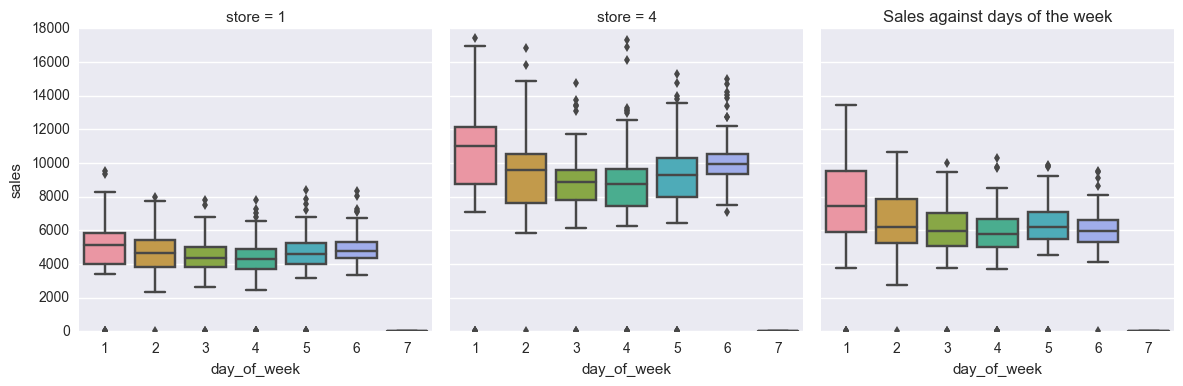

In [6]:
# As part of exploratory data analysis
# we'll plot a seaborn factorplot `for stores 1, 4, and 9 
# to see sales distibutions across the days of the week

sns.factorplot(x='day_of_week', y='sales',col='store', kind='box', data=stores)
plt.title("Sales against days of the week")
plt.show()

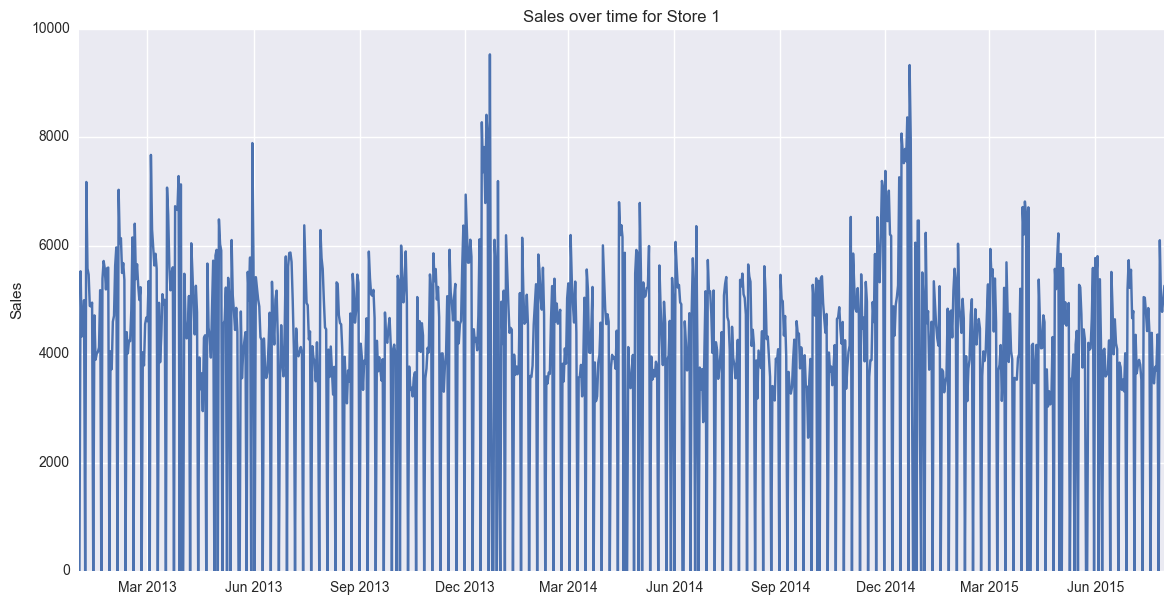

In [7]:
# Filter to store 1 and plot the sales 
# I'll use two alternative syntaxes here: this is plt.plot()

store1_data = stores.loc[(stores["store"] == 1),:].copy()
plt.figure(figsize=(14,7))
plt.plot(store1_data.index, store1_data["sales"])
plt.ylabel("Sales")
plt.title("Sales over time for Store 1")
plt.show()

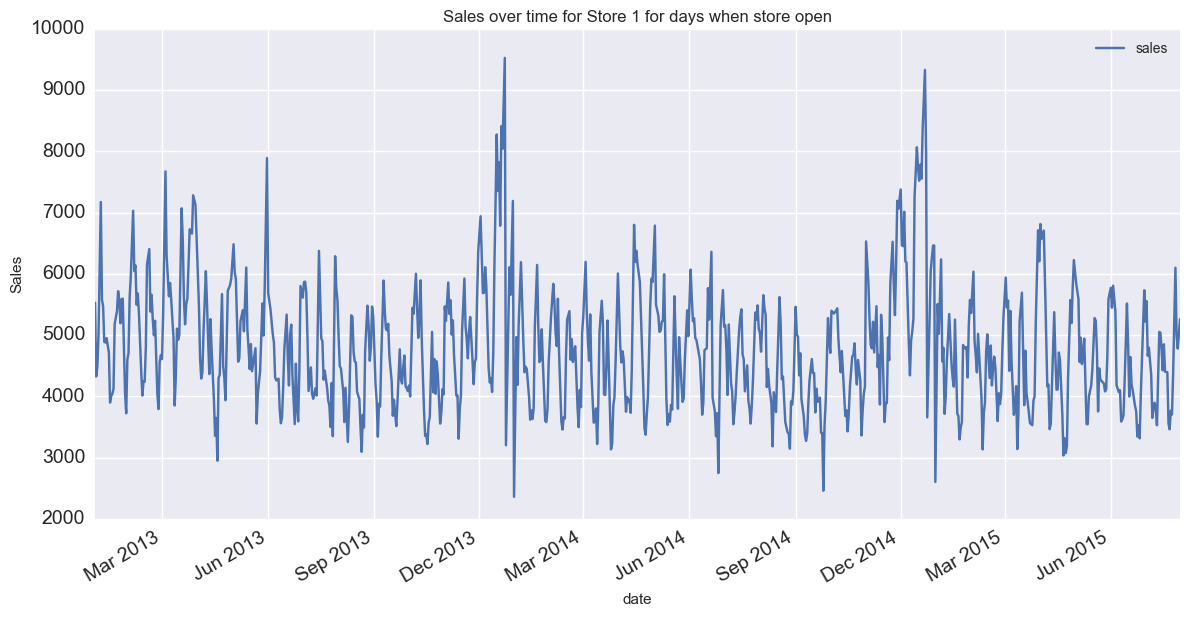

In [8]:
# Filter to store 1 only when it was open (not Sunday)
# and then I use this pandas syntax which uses the index for the x axis

store1_open_data = stores.loc[((stores.store == 1) & (stores.open == 1)),:].copy()
store1_open_data[['sales']].plot(figsize=(14,7), fontsize=14)
plt.ylabel("Sales")
plt.title("Sales over time for Store 1 for days when store open")
plt.show()

# Ways to Smooth

## Rolling means (and medians, etc.)

These data are quite noisy. The rolling mean (or median) takes a specified lag and uses the current time point and time points prior up to the specified lag to calculate the statistic, which is hence smoothed. Note that a lot of this functionality is quite new in pandas and still being developed, so some of the syntax is a bit strange and might be changed at a later date for newer versions. This is how it works at the moment in v0.19

In [9]:
# This operation creates an array object consisting of the index datetimes for the selection
date_ticks1 = stores.loc[((stores.store == 1) & (stores.open == 1)),:].index.to_pydatetime()

# Select out the sales and customer data for the selection 
s1_sales = stores.loc[((stores.store == 1) & (stores.open == 1)),:]['sales']
s1_cust = stores.loc[((stores.store == 1) & (stores.open == 1)),:]['customers']

# use pandas rolling function to create a rolling mean with a window of 7 observations smoothed
s1_sales_rollmean = s1_sales.rolling(window=10).mean()
s1_cust_rollmean = s1_cust.rolling(window=10).mean()

# normalise the data so they can be plotted on the same scale
s1_sales_norm = (s1_sales - s1_sales.mean()) / s1_sales.std()
s1_cust_norm = (s1_cust - s1_cust.mean()) / s1_cust.std()

# rolling for normalised version of data 
s1_sales_rollmean_norm = s1_sales_norm.rolling(window=7).mean()
s1_cust_rollmean_norm = s1_cust_norm.rolling(window=7).mean()

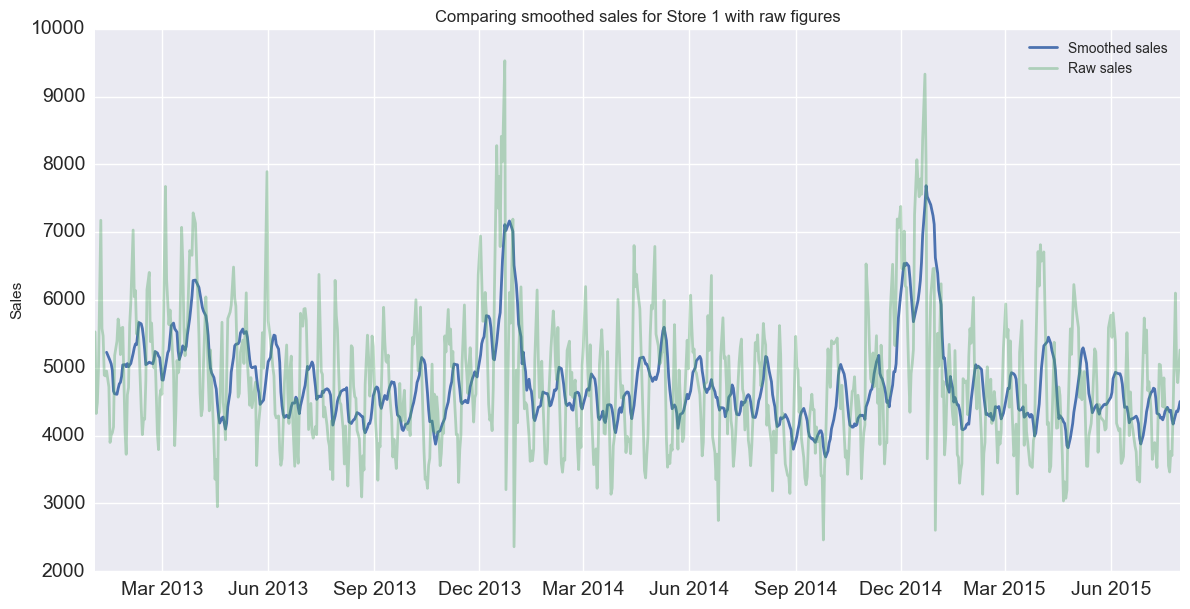

In [10]:
# let's see the effect of this with the smoothed sales data
plt.figure(figsize=(14,7))
plt.plot(date_ticks1, s1_sales_rollmean, alpha=1, lw=2, label="Smoothed sales")
plt.plot(date_ticks1, s1_sales, alpha=.4, lw=2, label="Raw sales")
plt.ylabel("Sales")
plt.title("Comparing smoothed sales for Store 1 with raw figures")
plt.legend()
plt.tick_params(labelsize=14)

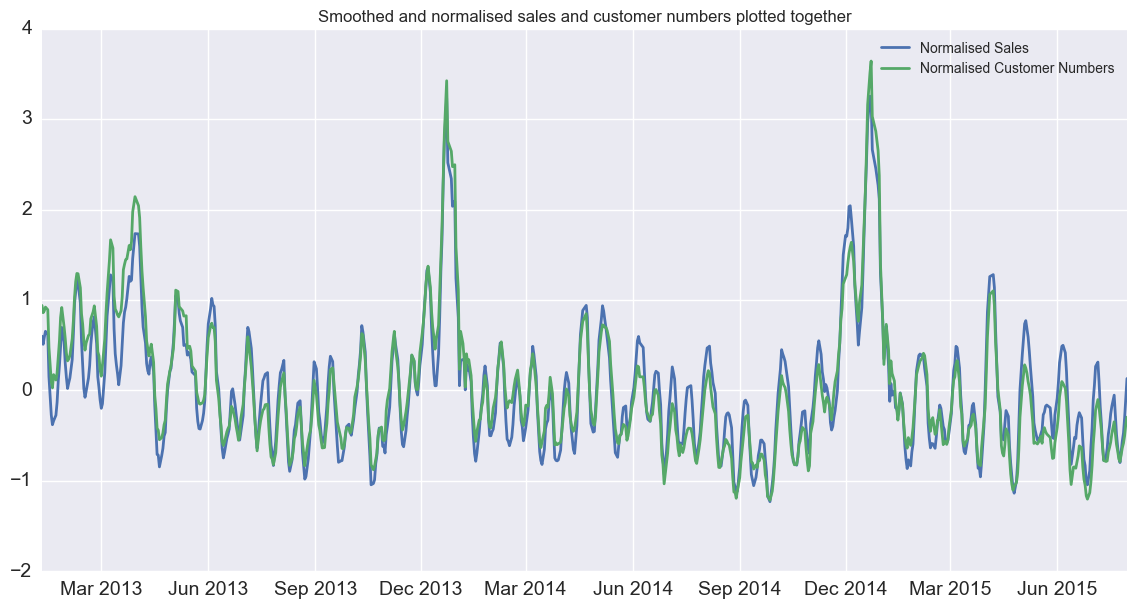

In [11]:
# let's compare the smoothed sales data with the smoothed customer numbers
# given the normalised figures, allowing them to be plotted on the same scale
# this allows us to more clearly tease out the relationships between the two


plt.figure(figsize=(14,7))
plt.plot(date_ticks1, s1_sales_rollmean_norm, alpha=1, lw=2, label="Normalised Sales")
plt.plot(date_ticks1, s1_cust_rollmean_norm, alpha=1, lw=2, label="Normalised Customer Numbers")
plt.title("Normalised sales and customer numbers ")
plt.legend()
plt.tick_params(labelsize=14)
plt.title("Smoothed and normalised sales and customer numbers plotted together")
plt.show()

### Parameters for `rolling` functions

**`rolling().mean()`** (as well as **`rolling().median()`**) can take these parameters:

- the first is the series to aggregate
- **`window`** is the number of days to include in the average
- **`center`** is whether the window should be centered on the date or use data prior to that date
- **`freq`** is on what level to roll-up the averages to (as used in **`resample`**). Either **`D`** for day, **`M`** for month or **`A`** for year, etc.

The resample strings for time periods are listed in the documentation [here](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)



In [12]:
# take a look at the raw data here
# we look at store 1 in 2014
s1_2014 = data.loc[((data.store == 1) & (data.year == 2014)),:].copy()
s1_2014.loc[s1_2014["month"]==1,:].head(12)

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,year,month
date,,,,,,,,,,
2014-01-01,1,3,0,0,0,0,a,1,2014,1
2014-01-02,1,4,4969,618,1,0,0,1,2014,1
2014-01-03,1,5,4190,552,1,0,0,1,2014,1
2014-01-04,1,6,5173,660,1,0,0,1,2014,1
2014-01-05,1,7,0,0,0,0,0,1,2014,1
2014-01-06,1,1,6194,649,1,1,0,1,2014,1
2014-01-07,1,2,5539,607,1,1,0,1,2014,1
2014-01-08,1,3,4931,589,1,1,0,1,2014,1
2014-01-09,1,4,4396,539,1,1,0,1,2014,1


In [13]:
# Calculate, for example, weekly median sales
# The 'W' string defines weekly resampling

weekly_store_sales_1 = s1_2014[['sales']].resample('W').median()
weekly_store_sales_1.head()

,sales
date,
2014-01-05,4190
2014-01-12,4486
2014-01-19,3776
2014-01-26,4597
2014-02-02,3789


In [14]:
# Look back at the raw data, take the first week and see there
# are five values for the days 2014-01-01 to 2014-01-05
print(np.median([4969,4190,5173,0,0]))

# While in the second week 2014-01-06 to 2014-01-12 there are
# seven values (if you check a calendar you will see 2014-01-06 was a Monday)
print(np.median([6194,5539,4931,4396,4486,4454,0]))

# hence the date given as the index is the end of the week aggregated (the Sunday)

4190.0
4486.0


In [15]:
weekly_store_sales_2 = s1_2014[['sales']].rolling(window=2, center=True).median()
weekly_store_sales_2.head(10)
# see further discussion in cell below

,sales
date,
2014-01-01,NaN
2014-01-02,2484.5
2014-01-03,4579.5
2014-01-04,4681.5
2014-01-05,2586.5
2014-01-06,3097.0
2014-01-07,5866.5
2014-01-08,5235.0
2014-01-09,4663.5


In [16]:
# taking a look back at the original figures we can see this has calculated a 2-day rolling median
# such that for example the first two days of the year are 0,4969
print(np.median([0,4969]))
# and then rolling the 2nd and 3rd days are 4969, 4190
print(np.median([4969,4190]))
# and then the 3rd and 4th days are 4190,5173
print(np.median([4190,5173]))

2484.5
4579.5
4681.5


In [17]:
# Calculate the weekly rolling median of sales for store 1 in 2014
# first we resample across the week and sum the values
# then we calculate a rolling window of 2 weeks and calculate the median

weekly_store_sales = s1_2014[['sales']].resample('W').sum().rolling(window=2, center=True).median()
weekly_store_sales.head()

,sales
date,
2014-01-05,NaN
2014-01-12,22166.0
2014-01-19,26977.0
2014-01-26,27028.0
2014-02-02,27910.0


In [18]:
# just to verify what this is doing - here is the resample per week with the summation
s1_2014[['sales']].resample('W').sum().head()

,sales
date,
2014-01-05,14332
2014-01-12,30000
2014-01-19,23954
2014-01-26,30102
2014-02-02,25718


In [19]:
# and the median of the first two weeks is then of 14332,30000
print(np.median([14332,30000]))
# and of weeks 2 and 3 is 30000 and 23954
print(np.median([30000,23954]))
# and of weeks 3 and 4 is 23954 and 30102
print(np.median([23954,30102]))

# so compare these numbers to the weekly_store_sales figures two cells up

22166.0
26977.0
27028.0


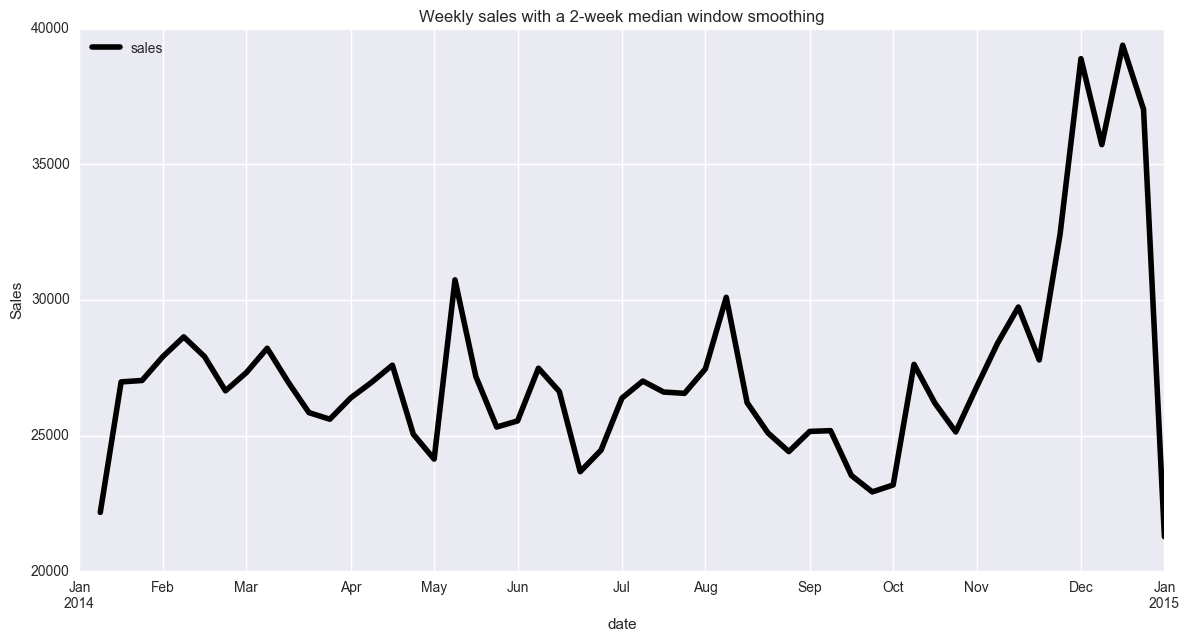

In [20]:
# here is a plot using the pandas plotting notation

s1_2014[['sales']].resample('W').sum().rolling(window=2, center=True).median().plot(style='k', figsize=(14,7), lw=4)
plt.ylabel("Sales")
plt.title("Weekly sales with a 2-week median window smoothing")
plt.show()

### Expanding mean

The "expanding mean" simply uses all datapoints up to the current time to calculate the mean, as opposed to a moving window. Plot the rolling mean and the expanded mean for store 1 sales in year 2014:

In [21]:
date_ticks = s1_2014.resample('W').index.to_pydatetime()

# so we resample to a weekly sum of sales, then take a mean rolling window of 2 weeks
rolling_mean = s1_2014[['sales']].resample('W').sum().rolling(window=2, center=True).mean()

# in this case we resample also to a weekly sum, but now we take an expanding mean
expanding_mean = s1_2014[['sales']].resample('W').sum().expanding().mean()
expanding_mean.head()

# this returns a future warning that I wasn't able to remove; note this syntax
# has been changing recently and seems likely it may change again

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':


,sales
date,
2014-01-05,14332.0
2014-01-12,22166.0
2014-01-19,22762.0
2014-01-26,24597.0
2014-02-02,24821.2


In [22]:
# so to clarify what the expanding mean is doing,
# here is the weekly resample we saw before
s1_2014[['sales']].resample('W').sum().head()

,sales
date,
2014-01-05,14332
2014-01-12,30000
2014-01-19,23954
2014-01-26,30102
2014-02-02,25718


In [23]:
# and you see that after the first two weeks is 14332,30000
print(np.mean([14332,30000]))
# and after the first three weeks is 14332,30000,23954
print(np.mean([14332,30000,23954]))
# and after the first four weeks is 14332,30000,23954,30102
print(np.mean([14332,30000,23954,30102]))

# and we see these correspond to the value two cells up from the expanding mean

22166.0
22762.0
24597.0


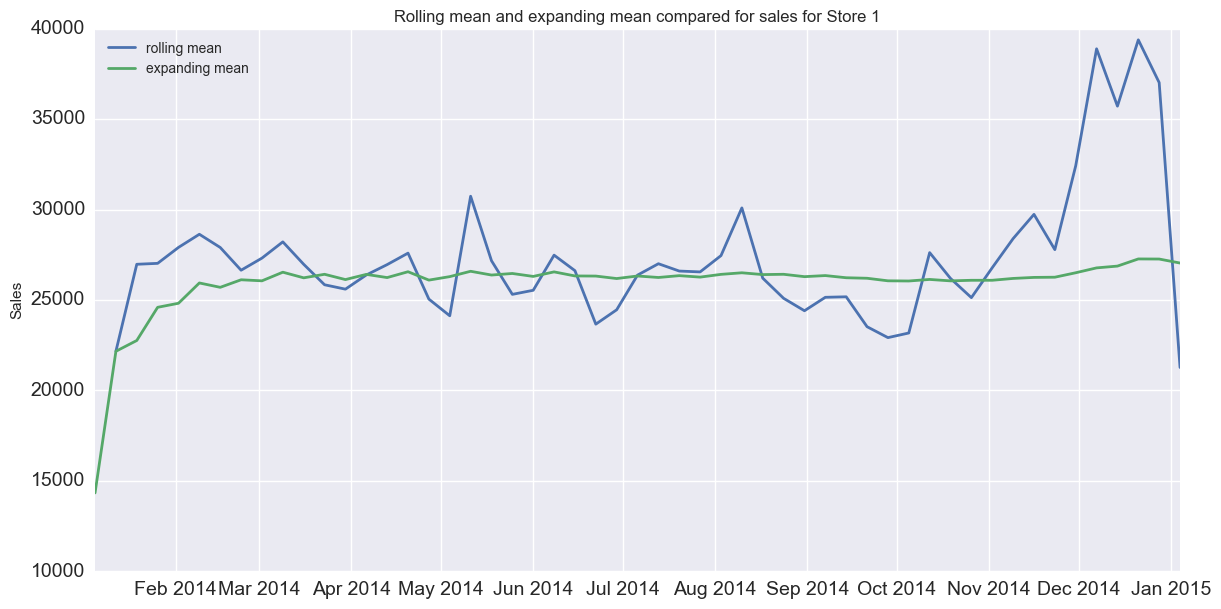

In [24]:
# so we plot these for comparison - the rolling mean is taking only the surrounding
# two weeks but the expanding mean carries on and takes all past values into account

plt.figure(figsize=(14,7))
plt.plot(date_ticks, rolling_mean, alpha=1, lw=2, label='rolling mean')
plt.plot(date_ticks, expanding_mean, alpha=1, lw=2, label='expanding mean')
plt.legend(loc='upper left')
plt.ylabel("Sales")
plt.title("Rolling mean and expanding mean compared for sales for Store 1")
plt.tick_params(labelsize=14)

### Exponentially weighted windows

But this expanding mean doesn't seem ideal - it somewhat arbitrarily allows the past to influence results equally, meaning if we simply started out plot at a later date we would get substantially different results. An exponentially weighted window is a way to deal with this by changing the impact of points in the past with a weighting. They are certainly one of the most common and effective ways of averaging out noise in timeseries data. The averaging is done with an "exponential decay" on the contribution of prior means, decreasing the contribution of timepoints further in the past.

The (adjusted) exponentially weighted mean for time $t$ is defined as:

### $$ x_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2x_{t-1} + ... + (1 - \alpha)^{t}x_0} {1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^{t}} $$

There is some discussion on this in the pandas documentation [here](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows)


**Plot the rolling and exponentially weighted mean of sales data for the winter months of store 1 sales in 2014:**

In [25]:
s1_winter14 = s1_2014.loc[(s1_2014.month > 9),:].copy()

# so the rolling mean is taking a rolling window and calculating a mean as we saw
rolling_mean = s1_winter14[['sales']].rolling(window=5, center=True).mean()

# the expanding mean takes all time for its mean calculation (that is from
# the start of the time we set which is beginning Q4 2014)
expanding_mean = s1_winter14[['sales']].expanding().mean()

# the exponentially weighted mean - the span is the alpha term and defines
# the strength of the decay, such that a higher span means a slower decay
# that would more closely resemble expanding mean. Also note that 
# ewm stands for exponentially weighted method
exp_weighted_mean = s1_winter14[['sales']].ewm(span=10).mean()

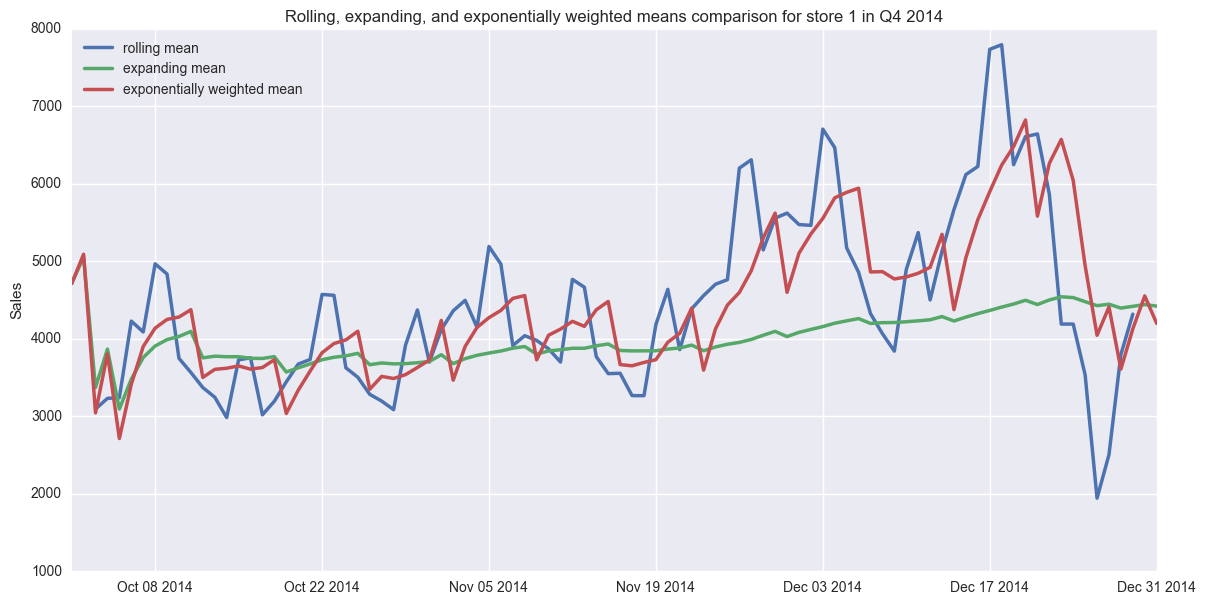

In [26]:
# plot all this (try changing parameters to see the effect)

plt.figure(figsize=(14,7))
plt.plot(rolling_mean.index, rolling_mean["sales"],lw=2.5, label="rolling mean")
plt.plot(expanding_mean.index, expanding_mean["sales"], lw=2.5, label="expanding mean")
plt.plot(exp_weighted_mean.index, exp_weighted_mean["sales"],lw=2.5, label="exponentially weighted mean")
plt.legend(loc="upper left")
plt.ylabel("Sales")
plt.title("Rolling, expanding, and exponentially weighted means comparison for store 1 in Q4 2014")
plt.show()

# Trendlines

Let's look back at a section of the data with a clear trend and look at how we could fit a trendline with numpy.

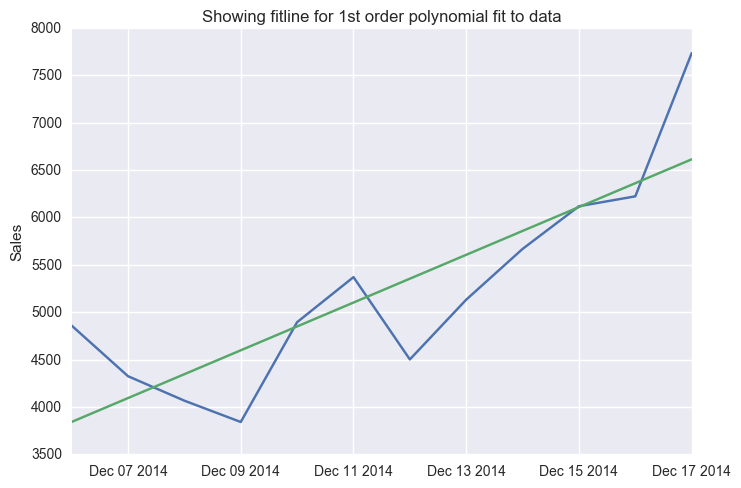

Fitline parameters:
 
252 x + 3842


In [27]:
# just subselect this increasing section
increasing_section=rolling_mean[datetime.date(2014,12,6):datetime.date(2014,12,17)]

# fit a one dimensional linear regression to this data
line_coef = np.polyfit(range(0, len(increasing_section)),increasing_section["sales"],1)
polynomial = np.poly1d(line_coef)

# plot the linear regression along with the data
plt.plot(increasing_section.index, increasing_section["sales"], label="Data")
plt.plot(increasing_section.index, polynomial(range(0, len(increasing_section))), label="Order 1 fit line")
plt.ylabel("Sales")
plt.title("Showing fitline for 1st order polynomial fit to data")
plt.show()

# view the function fitted
print("Fitline parameters:")
print(polynomial)

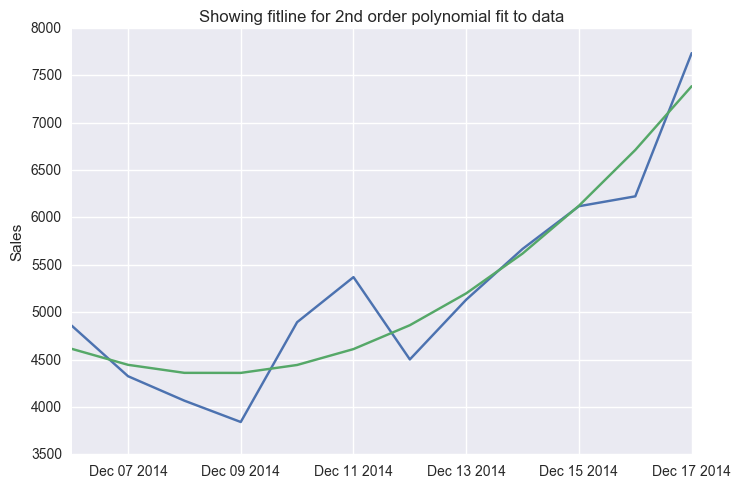

Fitline parameters:
      2
42.1 x - 211 x + 4613


In [28]:
# try two dimensional fit
line_coef_2 = np.polyfit(range(0, len(increasing_section)),increasing_section["sales"],2)
polynomial_2 = np.poly1d(line_coef_2)

# plot the regression along with the data
plt.plot(increasing_section.index, increasing_section["sales"], label="Data")
plt.plot(increasing_section.index, polynomial_2(range(0, len(increasing_section))), label="Order 2 fit line")
plt.ylabel("Sales")
plt.title("Showing fitline for 2nd order polynomial fit to data")
plt.show()

# view the function fitted
print("Fitline parameters:")
print(polynomial_2)

#  Autocorrelation and the autocorrelation function (acf)

Unlike regular randomly sampled data, time series data has an ordering - in time. This provides extra information and implies additional analysis methods. Of course, there may not be any extra information if, for example, the system from which we sample would be steady-state. While in previous weeks, our analyses has been concerned with the correlation between two or more variables (height and weight, education and salary, etc.), in time series data, autocorrelation is in a sense a measure of _how correlated a variable is with itself_ (or rather, itself at different points in time). We are hence interested in patterns or trends in the data.

Hence in stock market data the stock price at one point is correlated with the stock price of the point directly prior in time. In sales data, sales on a Saturday are correlated with sales on the next Saturday and the previous Saturday, as well as other days to greater or lesser extent. We might expect for example that in stock market data the autocorrelation will be strong from one moment to the next but weak as the time difference grows larger.

Below is the formula for the autocorrelation funtion (acf):

$\text{Given measurements } x_1, x_2, x_3 ... x_n \text{ at time points } t_1, t_2, t_3 ... t_n:$

### $$acf = \frac{\sum_{t=k+1}^{n}\left(\;x_t - \bar{x}\;\right)\left(\;x_{t-k} - \bar{x}\;\right)}{\sum_{t=1}^n\left(\;x_t - \bar{x}\;\right)^2}$$

Remember comparisons to correlation and covariance for similar concepts. The autorcorrelation (acf) will lie between -1 and +1. 

## Computing Autocorrelation

To compute autocorrelation, we fix a lag which is the delta between the given point and the prior point used to compute the correlation. With a lag value of 1, we'd compute how correlated a value is with the prior one. With a lag value of 10, we'd compute how correlated a variable is with one 10 time points earlier. In the acf equation above, the lag is the _k_ term.

**Calculate the autocorrelation for store 1 sales for day and week periods with lag 1:**

In [29]:
s1 = data.loc[((data["store"] == 1)),:].copy()

autocorr_day_lag1 = s1['sales'].autocorr(lag=1)
autocorr_week_lag1 = s1['sales'].resample('W').sum().autocorr(lag=1)

# so this is the autocorrelation of each day with its previous day
print(autocorr_day_lag1)

# this is the autocorrelation of each week with its previous week
print(autocorr_week_lag1)

# so slight negative correlations, but hard to interpret
# this is perhaps a kind of 'regression to the mean'

-0.127325143391
-0.159059353245


**Calculate the autocorrelation for store 1 (including days closed) for day with lag 7:**

In [30]:
s1 = data.loc[((data.store == 1)),:].copy()

autocorr_day_lag7 = s1['sales'].autocorr(lag=7)

# so this is the seasonal weekly trend, each 7 day cycle
# is autocorrelated to this extent
print(autocorr_day_lag7)

# so there is clearly a weekly trend

0.630719243284


**Calculate the autocorrelation for store 1 through 7 days:**

In [31]:
s1 = data.loc[((data.store == 1)),:].copy()

# so the autocorrelation in a range of lags from 1-7
s1_autocorrelations = [s1["sales"].autocorr(lag=l) for l in range(1,8)]
s1_autocorrelations[0:7]

[-0.12732514339140216,
 -0.034787155707946951,
 0.064736112912999924,
 -0.0018114479109864311,
 -0.109457935288973,
 -0.22963935576549277,
 0.63071924328402873]

**Let's calculate autocorrelation manually**

In [32]:
subset=s1[["sales"]].iloc[50:54]
subset

,sales
date,
2013-02-20,5660
2013-02-21,5261
2013-02-22,5000
2013-02-23,5237


In [33]:
# calculate the mean

global_mean=np.mean(subset["sales"])
global_mean

5289.5

In [34]:
# calculate acf according to formula above

numerator=((subset["sales"].iloc[3]-global_mean)*(subset["sales"].iloc[2]-global_mean))+((subset["sales"].iloc[2]-global_mean)*(subset["sales"].iloc[1]-global_mean))+((subset["sales"].iloc[1]-global_mean)*(subset["sales"].iloc[0]-global_mean))
denominator=((subset["sales"].iloc[3]-global_mean)**2)+((subset["sales"].iloc[2]-global_mean)**2)+((subset["sales"].iloc[1]-global_mean)**2)+((subset["sales"].iloc[0]-global_mean)**2)
numerator/denominator

0.0573795120387805

In [35]:
# use statsmodels acf to return result

from statsmodels.tsa.stattools import acf

acf(subset["sales"], nlags=1)

array([ 1.        ,  0.05737951])

In [36]:
# pandas returns a different result I have not been able to match, it seems to use
# a different formula perhaps optimised for faster results on large datasets
# this seems to not work well on this small dataset here however

subset["sales"].autocorr(lag=1)

0.20201668225292455

In [37]:
# but if you look at the longer dataset then you get good agreement
# so this is fine as long as you have more than eg 20 points or so
# but worth checking these things and comparing always what the function
# is doing!

print(s1['sales'].autocorr(lag=1))
print(acf(s1["sales"], nlags=1))

-0.127325143391
[ 1.         -0.12703786]


**Plot the autocorrelation for store 1 for 31 days:**

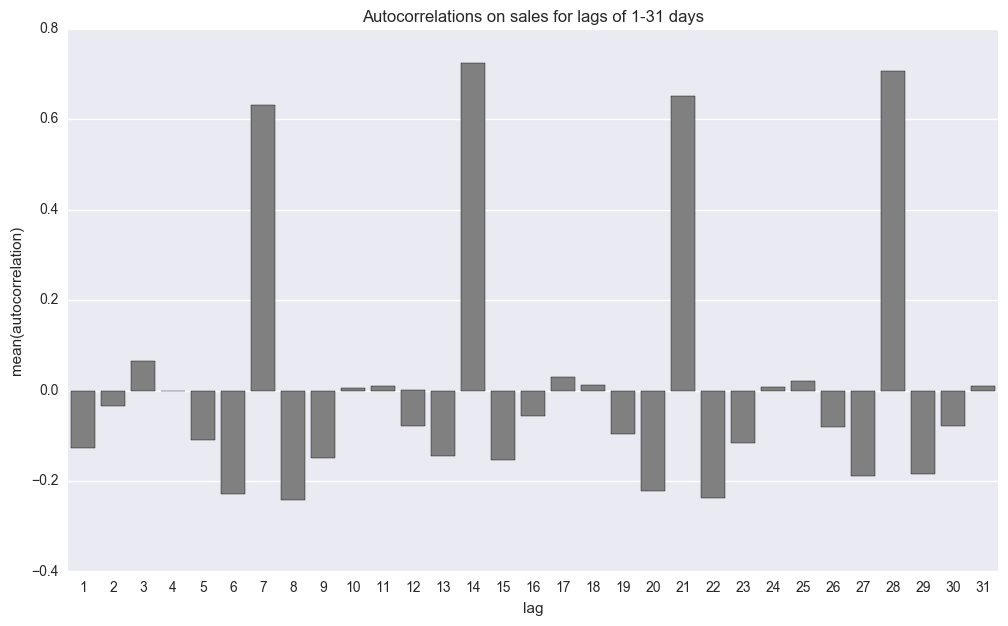

In [38]:
# calculating a range of autocorrelation lags 1-31 days and plotting

s1_autocorrelations = [s1.sales.autocorr(lag=l) for l in range(1,32)]
s1autocorr = pd.DataFrame({'lag':range(1,32), 'autocorrelation':s1_autocorrelations})
plt.figure(figsize=(12,7))
sns.barplot(x=s1autocorr.lag, y=s1autocorr.autocorrelation, color='grey')
plt.title("Autocorrelations on sales for lags of 1-31 days")
plt.show()

## Statsmodels to help

The pandas functions are quite recent. In the past people would use statsmodels and
this still has some nice features, for example to help plotting a range of lags.

**Load the `acf` and `plot_acf` functions from statsmodels to plot the autocorrelation.**

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

**Calculate and plot the autocorrelation again using the statsmodels functions:**

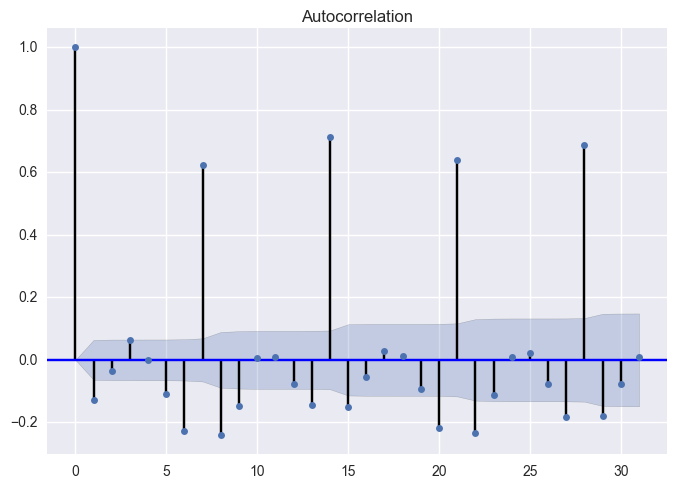

In [40]:
# so the statsmodels function creates the list of lags to calculate
# and does this for us, and includes a plotting function too

plt.figure(figsize=(12,7))
plot_acf(s1['sales'].values, lags=31)
plt.show()

In [41]:
acf(s1['sales'].values, nlags=31)

array([ 1.        , -0.12703786, -0.03469319,  0.06454937, -0.00180766,
       -0.10904274, -0.22783504,  0.6248786 , -0.2401515 , -0.14869745,
        0.00624578,  0.01006485, -0.07707318, -0.14363042,  0.71435429,
       -0.15188393, -0.05551585,  0.02901103,  0.01113764, -0.09400308,
       -0.21875595,  0.63865175, -0.23360339, -0.11384778,  0.00788378,
        0.02095157, -0.07841381, -0.18374454,  0.68804836, -0.17930762,
       -0.07734379,  0.01060628])

# Conclusion 

We covered a lot of functions here. Please go back and re-read and then practice. You could explore different autocorrelations, different plottings, averages etc etc. For example what about the seasonal trend in sales over a whole year, etc etc. For some light reading try the pandas documentation [here](http://pandas.pydata.org/pandas-docs/stable/timeseries.html). Do play and around and get used to the syntax.